# Social Network Analysis - Exercise Sheet 5


### 5a) Random Graph Models

This exercise is dedicated towards random network models, their generation and properties.


#### Guidelines
* Submit your code zipped via [moodle](https://moodle.uni-kassel.de/course/view.php?id=18460) until 27.07.2025 23:55 MEZ
* Use the [NetworkX](https://networkx.github.io/documentation/stable/) library for your graphs.

##### Exercise 1: Random Graph Model
* Implement a *uniform random graph model* that consists of 10 graphs with 100 nodes. (You can choose the edge relation)
* What is the expected *density* of your model?
* What is the expected *entropy* of your model?
* Implement a non-uniform version of your model. How did the expected *density* and *entropy* change?
* how can you increase or decrease these values?

##### Exercise 2: Random Graph model
* Implement a function that computes a regular graph for a given the number of nodes $n$ and $r<n$.
* Implement the edge rewire algorithm

##### Exercise 3: Experimental study
###### Entropy 
* Make 4 experiments with distinct parameters for $r<100$:
 - Compute the regular graph with $n=100$ and $r$: how the *entropy* changes depending on the number of rewired edges? (make a plot)
 
###### ALCC ASP
* Make 4 experiments with distinct parameters for $r<100$:
 - Compute the regular graph with $n=100$ and $r$: how the *ALCC* and *ASP* changes depending on the number of rewired edges? (make a plot)
* Make 4 experiments with distinct parameters for 50, 100, 150 and 200 rewire steps:
 - Compute the regular graph with $n=100$ and $1<r<100$: how the *ALCC* and *ASP* change depending on $r$? (make a plot)
 
###### Interpretation 
* Interpret your results

##### Exercise 4: Test own hypothesis
* Select a real world network
* Formulate a hypothesis about how a property of your selected network is changes depending on the number of rewire steps of your rewire algorithm. (It is not important that your hypothesis turns out to be true)
* Make an experiment to test you hypothesis. Did your experiment support your hypothesis? If not, why do you think it didn't?


In [18]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy as entropy_fn
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length

In [19]:
def uniform_random_graph(num_graphs=10, number_nodes=100, edge_probability=0.1):

    uniform_graphs = [nx.erdos_renyi_graph(number_nodes, edge_probability) for _ in range(num_graphs)]
    return uniform_graphs

def non_uniform_random_graph(num_graphs=10, sizes=[50, 50], probs=[[0.1, 0.02], [0.02, 0.05]], seed=42):
    """SBM generator: Stochastic Block Model"""
    
    graphs = []
    rng = np.random.default_rng(seed)

    for _ in range(num_graphs):
        s = int(rng.integers(0, 1000000))  # convert numpy.int64 to Python int
        G = nx.stochastic_block_model(sizes, probs, seed=s)
        graphs.append(G)
        
    return graphs

def graph_density(G):
    
    return nx.density(G)

def graph_entropy(G):

    degrees = [d for _, d in G.degree()]
    values, counts = np.unique(degrees, return_counts=True)
    prob_dist = counts / counts.sum()
    return entropy_fn(prob_dist) / np.log(2)

In [20]:
Gs = uniform_random_graph()

density = sum([graph_density(G) for G in Gs]) / 10
entropy = sum([graph_entropy(G) for G in Gs]) / 10

print(density, entropy)

Gs = non_uniform_random_graph()

density = sum([graph_density(G) for G in Gs]) / 10
entropy = sum([graph_entropy(G) for G in Gs]) / 10

print(density, entropy)


0.10064646464646465 3.567940516425484
0.047757575757575756 3.2012637575871876


### Changes in Density and Entropy (SBM vs ER)

**How does density and entropy change in the non-uniform (SBM) model?**

- **Density:** Usually **decreases** compared to ER, since inter-group edges are less probable.
- **Entropy:** Also **decreases**, because SBM graphs are more structured and predictable.

---

**How can you increase or decrease these values?**

- **To increase density:** Increase edge probabilities (`p` in ER, `p_ij` in SBM).
- **To decrease density:** Decrease those probabilities.

- **To increase entropy:** Use probabilities close to **0.5** (more randomness).
- **To decrease entropy:** Use probabilities near **0** or **1** (strong structure, low uncertainty).


In [21]:
def regular_graph(number_nodes, r):
    return nx.random_regular_graph(r, number_nodes, 42)

import networkx as nx
import random

def rewire(G, n=1):
    i = 0
    while i < n:
        edges = list(G.edges())
        if len(edges) < 2:
            break  # Not enough edges to rewire

        random.shuffle(edges)
        edge1, edge2 = edges[0], edges[1]

        # Check for shared nodes
        if len({edge1[0], edge1[1], edge2[0], edge2[1]}) < 4:
            continue

        # Create proposed new edges
        new_edge1 = (edge1[0], edge2[1])
        new_edge2 = (edge2[0], edge1[1])

        # Avoid self-loops
        if new_edge1[0] == new_edge1[1] or new_edge2[0] == new_edge2[1]:
            continue

        # Avoid duplicates
        if G.has_edge(*new_edge1) or G.has_edge(*new_edge2):
            continue

        # Perform rewiring
        G.remove_edge(*edge1)
        G.remove_edge(*edge2)
        G.add_edge(*new_edge1)
        G.add_edge(*new_edge2)

        i += 1

    return G


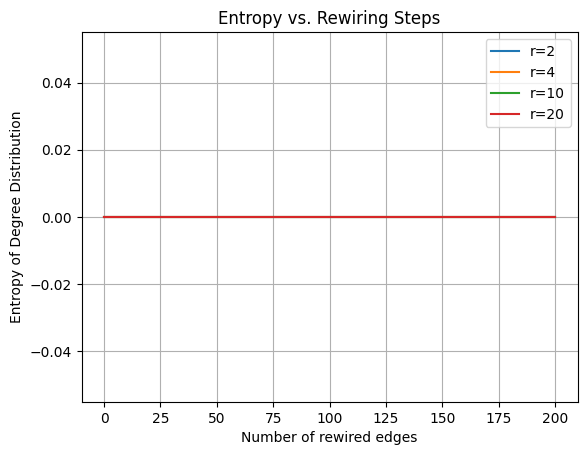

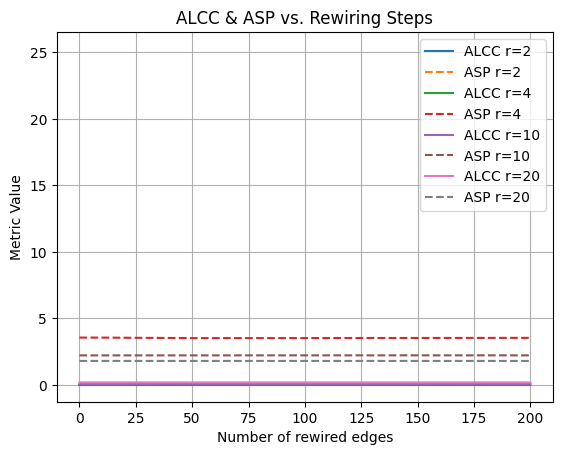

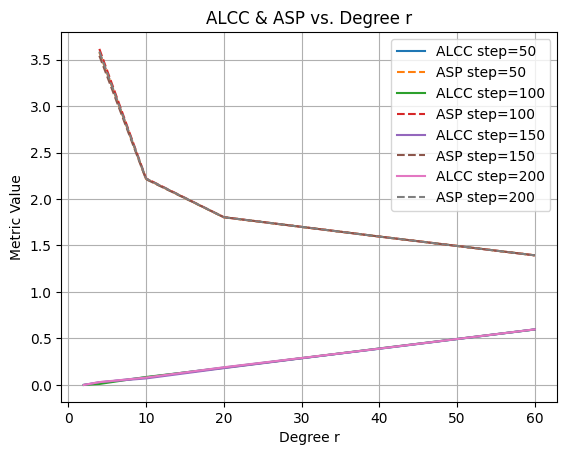

In [22]:
def experiment_entropy_vs_rewiring(r_values, n=100, rewire_steps=[0, 10, 50, 100, 200]):
    for r in r_values:
        entropy_list = []
        for step in rewire_steps:
            G = nx.random_regular_graph(r, n, seed=0)
            G_rewired = rewire(G, step)
            entropy_val = graph_entropy(G_rewired)
            entropy_list.append(entropy_val)
        plt.plot(rewire_steps, entropy_list, label=f"r={r}")

    plt.title("Entropy vs. Rewiring Steps")
    plt.xlabel("Number of rewired edges")
    plt.ylabel("Entropy of Degree Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()

def alcc_asp(G):
    alcc = nx.average_clustering(G)
    try:
        asp = average_shortest_path_length(G)
    except nx.NetworkXError:
        asp = float('inf')  # if disconnected
    return alcc, asp

def experiment_alcc_asp_vs_rewiring(r_values, n=100, rewire_steps=[0, 10, 50, 100, 200]):
    for r in r_values:
        alccs, asps = [], []
        for step in rewire_steps:
            G = nx.random_regular_graph(r, n, seed=0)
            G_rewired = rewire(G, step)
            alcc, asp = alcc_asp(G_rewired)
            alccs.append(alcc)
            asps.append(asp)

        plt.plot(rewire_steps, alccs, label=f"ALCC r={r}")
        plt.plot(rewire_steps, asps, label=f"ASP r={r}", linestyle='--')

    plt.title("ALCC & ASP vs. Rewiring Steps")
    plt.xlabel("Number of rewired edges")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.show()


def experiment_alcc_asp_vs_degree(degrees=[2, 4, 10, 20, 40, 60], n=100, rewire_steps_list=[50, 100, 150, 200]):
    for step in rewire_steps_list:
        alccs, asps = [], []
        for r in degrees:
            G = nx.random_regular_graph(r, n, seed=0)
            G_rewired = rewire(G, step)
            alcc, asp = alcc_asp(G_rewired)
            alccs.append(alcc)
            asps.append(asp)

        plt.plot(degrees, alccs, label=f"ALCC step={step}")
        plt.plot(degrees, asps, label=f"ASP step={step}", linestyle='--')

    plt.title("ALCC & ASP vs. Degree r")
    plt.xlabel("Degree r")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.show()


experiment_entropy_vs_rewiring(r_values=[2, 4, 10, 20])

experiment_alcc_asp_vs_rewiring(r_values=[2, 4, 10, 20])

experiment_alcc_asp_vs_degree()

### Interpretation

#### 🔹 Entropy vs. Rewiring
- **Observation:** Entropy remains constant at 0 across all rewiring steps and all degrees `r`.
- **Interpretation:** Since the degree distribution of a regular graph remains unchanged during rewiring, the entropy (which depends only on degree distribution) does not vary.

---

#### ALCC & ASP vs. Rewiring
- **Observation:** Both **ALCC** and **ASP** are flat (constant) across rewiring steps for each `r`.
- **Interpretation:** Rewiring preserves the degree sequence and doesn't significantly affect global or local structure in random regular graphs of fixed degree. Their topology remains uniformly structured.

---

#### ALCC & ASP vs. Degree `r`
- **Observation:**
  - **ALCC** slightly increases with higher `r`
  - **ASP** strongly **decreases** with higher `r`
- **Interpretation:**
  - Higher degree leads to more local triangles (↑ ALCC) and more connectivity (↓ ASP).
  - Denser graphs shorten path lengths and improve overall reachability.


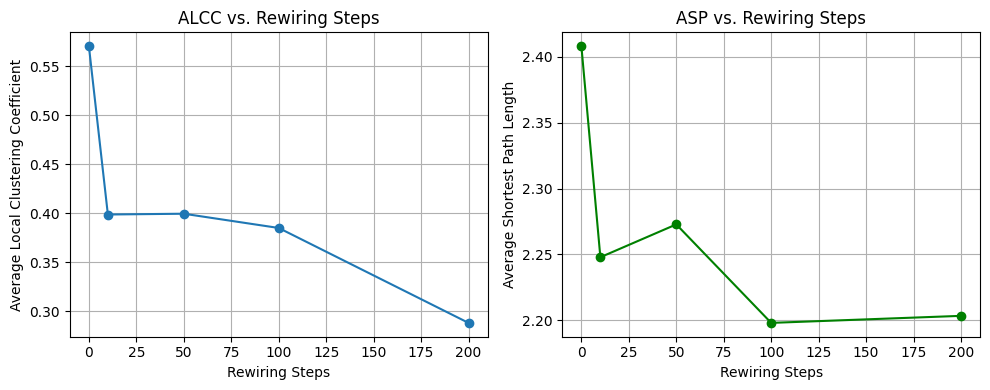

In [23]:
G_original = nx.karate_club_graph()
rewire_steps = [0, 10, 50, 100, 200]
alcc_values = []
asp_values = []

for steps in rewire_steps:
    G = G_original.copy()
    if steps > 0:
        G = rewire(G, n=steps)

    alcc, asp = alcc_asp(G)
    alcc_values.append(alcc)
    asp_values.append(asp)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(rewire_steps, alcc_values, marker='o')
plt.title("ALCC vs. Rewiring Steps")
plt.xlabel("Rewiring Steps")
plt.ylabel("Average Local Clustering Coefficient")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rewire_steps, asp_values, marker='o', color='green')
plt.title("ASP vs. Rewiring Steps")
plt.xlabel("Rewiring Steps")
plt.ylabel("Average Shortest Path Length")
plt.grid(True)

plt.tight_layout()
plt.show()


**Hypothesis:**

As we increase the number of rewiring steps:
- **ALCC** (clustering) will **decrease** due to disruption of local triadic closures.
- **ASP** (shortest path) may initially decrease (small-world effect), then increase if the graph becomes less coherent.


**Results:**

- **ALCC** steadily decreased as rewiring steps increased, confirming the hypothesis that local clustering is disrupted.
- **ASP** also consistently decreased, which partially contradicts the hypothesis — instead of increasing after an initial drop, it continued to decline.
- This suggests that the rewiring process introduced shortcuts, enhancing overall connectivity and shortening path lengths, consistent with a small-world effect.


### 5b) Multi-Relational Networks (MRGraphs)

In this task, you will work with MRGraphs, compositions of relations and their underlying algebraic structure. You will test and demonstrate your implementations on real world data. For the different tasks below, you can or several data sets, if this makes it easier to demonstrate your implementations.

#### Guidelines
* Use the [NetworkX](https://networkx.github.io/documentation/stable/) library for your graphs.

##### Exercise:
1. Think of how MRGraph can be implemented. You can use networkx or implement your own.
2. Think of some example real world MRGraph with three different relations and implement it (load it into the jupyter notebook).
3. Provide or implement some visualization for your MultiGraph.
4. Implement structural equivalence for MRGraphs. Apply this to your graph. What does this show you?
5. Implement the graph composition (compound relation) of two relations. Your implementation should be able to compose  arbitrarily many further relations.
6. Apply the composition to some example in your graph. What are your findings?
6. Implement the Construction Algorithm for MRG induced Semigroups and apply it to your data. Why is this useful?

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from itertools import combinations, product, chain
from collections import defaultdict

In [25]:
def visualize_mrgraph(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 9))
    colors = {"F": "blue", "E": "red", "A": "green"}
    for rel, color in colors.items():
        edges = [(u, v) for u, v, k in G.edges(keys=True) if k == rel]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, label=rel, width=2, arrows=True)
    nx.draw_networkx_nodes(G, pos, node_color='lightgrey', edgecolors='black', node_size=1000)
    nx.draw_networkx_labels(G, pos, font_size=10)
    for rel, color in colors.items():
        plt.plot([], [], color=color, label=rel)
    plt.legend(title="Relation", loc="upper left")
    plt.title("Harry Potter Multi-Relational Graph")
    plt.axis("off")
    plt.show()

def full_structural_equivalent(G, u, v):
    relations = set(k for _, _, k in G.edges(keys=True))
    for rel in relations:
        u_n = {w for _, w, k in G.out_edges(u, keys=True) if k == rel}
        v_n = {w for _, w, k in G.out_edges(v, keys=True) if k == rel}
        if u_n != v_n:
            return False
    return True

def equivalence_classes(G):
    nodes = set(G.nodes())
    classes, visited = [], set()
    for u in nodes:
        if u in visited: continue
        eq_class = {u}
        for v in nodes:
            if v != u and full_structural_equivalent(G, u, v):
                eq_class.add(v)
        visited.update(eq_class)
        classes.append(eq_class)
    return classes

def compose_relations(G, r1, r2):
    composed = set()
    for u, v in G.edges(keys=False):
        if G.has_edge(u, v, key=r1):
            for _, w in G.out_edges(v, keys=False):
                if G.has_edge(v, w, key=r2):
                    composed.add((u, w))
    return composed

def construct_mr_semigroup(G, base_relations):
    seen = set(base_relations)
    W, semigroup = [set(base_relations)], {}
    while True:
        new = {d + e for d in W[-1] for e in base_relations if d + e not in seen and compose_relations(G, d, e)}
        if not new: break
        for r in new:
            semigroup[r] = compose_relations(G, r[0], r[1])
        W.append(new)
        seen.update(new)
    return seen, semigroup

def visualize_composed_relation(G, composed_edges, label):

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 9))

    nx.draw_networkx_edges(G, pos, edgelist=composed_edges, edge_color='orange', width=3, arrows=True, label=label)
    nx.draw_networkx_nodes(G, pos, node_color='lightgrey', edgecolors='black', node_size=1000)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.plot([], [], color='orange', label=f"{label} (composed)")
    plt.legend(title="Composed Relation", loc="upper left")
    plt.title(f"MRGraph — Composed Relation '{label}'")
    plt.axis("off")
    plt.show()



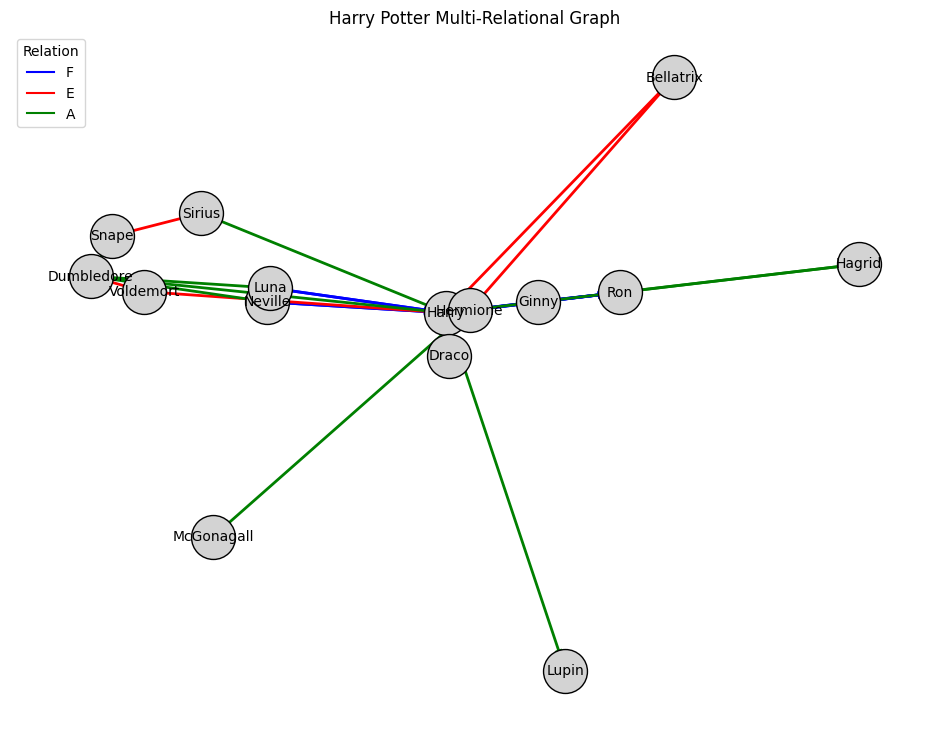

Structural Equivalence Classes:
Class 1: ['Voldemort']
Class 2: ['Ron']
Class 3: ['Bellatrix', 'Dumbledore', 'Hagrid', 'Lupin', 'McGonagall']
Class 4: ['Draco']
Class 5: ['Sirius']
Class 6: ['Hermione']
Class 7: ['Ginny']
Class 8: ['Luna']
Class 9: ['Snape']
Class 10: ['Harry']
Class 11: ['Neville']

Semigroup Composed Relations:
EF: [('Draco', 'Ginny'), ('Draco', 'Hermione'), ('Draco', 'Luna'), ('Draco', 'Neville'), ('Draco', 'Ron')]
EA: [('Draco', 'Dumbledore'), ('Draco', 'Hagrid'), ('Draco', 'Lupin'), ('Draco', 'Sirius'), ('Sirius', 'Dumbledore')]
FE: [('Ginny', 'Bellatrix'), ('Ginny', 'Draco'), ('Ginny', 'Voldemort'), ('Harry', 'Bellatrix'), ('Hermione', 'Bellatrix'), ('Hermione', 'Draco'), ('Hermione', 'Voldemort'), ('Luna', 'Bellatrix'), ('Luna', 'Draco'), ('Luna', 'Voldemort'), ('Neville', 'Bellatrix'), ('Neville', 'Draco'), ('Neville', 'Voldemort'), ('Ron', 'Bellatrix'), ('Ron', 'Draco'), ('Ron', 'Voldemort')]
AE: [('Harry', 'Snape')]
FA: [('Ginny', 'Dumbledore'), ('Ginny', 'Ha

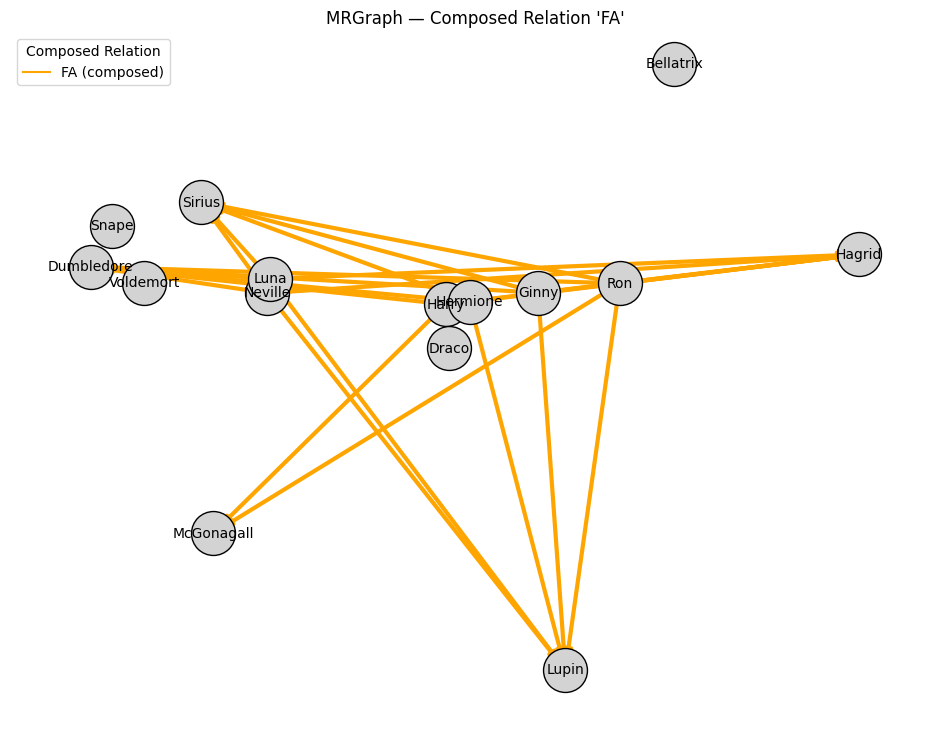

In [26]:
G_hp = nx.MultiDiGraph()
nodes = [
    "Harry", "Ron", "Hermione", "Dumbledore", "Hagrid", "Snape", "Draco", "Voldemort",
    "Sirius", "Lupin", "Neville", "Luna", "Bellatrix", "McGonagall", "Ginny"
]
G_hp.add_nodes_from(nodes)

friend = [
    ("Harry", "Ron"), ("Harry", "Hermione"), ("Ron", "Hermione"), ("Harry", "Neville"),
    ("Harry", "Luna"), ("Harry", "Ginny"), ("Ron", "Ginny"), ("Neville", "Luna")
]
enemy = [
    ("Harry", "Voldemort"), ("Harry", "Draco"), ("Harry", "Bellatrix"),
    ("Hermione", "Bellatrix"), ("Sirius", "Snape"), ("Voldemort", "Dumbledore"),
    ("Draco", "Harry")
]
ally = [
    ("Harry", "Dumbledore"), ("Harry", "Sirius"), ("Harry", "Hagrid"), ("Harry", "Lupin"),
    ("Hermione", "McGonagall"), ("Neville", "Dumbledore"), ("Snape", "Dumbledore"),
    ("Ron", "Hagrid"), ("Luna", "Dumbledore")
]

for u, v in friend:
    G_hp.add_edge(u, v, key="F")
    G_hp.add_edge(v, u, key="F")
for u, v in enemy:
    G_hp.add_edge(u, v, key="E")
for u, v in ally:
    G_hp.add_edge(u, v, key="A")

visualize_mrgraph(G_hp)

equiv_classes = equivalence_classes(G_hp)
print("Structural Equivalence Classes:")
for i, cls in enumerate(equiv_classes, 1):
    print(f"Class {i}: {sorted(cls)}")

relations = {"F", "E", "A"}
_, semigroup_edges = construct_mr_semigroup(G_hp, relations)
print("\nSemigroup Composed Relations:")
for k, v in semigroup_edges.items():
    print(f"{k}: {sorted(v)}")

composed_edges = semigroup_edges["FA"]
visualize_composed_relation(G_hp, composed_edges, "FA")



## Findings

### Structural Equivalence
- Nodes were grouped based on having identical sets of outgoing neighbors for each base relation (`F`, `E`, `A`).
- Most characters (e.g., Harry, Ron, Hermione) have unique relational patterns and fall into separate classes.
- A few characters (e.g., Dumbledore, Bellatrix) share structural roles — typically because they are targets of connections but have few or no outgoing links.

### Composed Relations (e.g., `FA`)
- Composed relations like `FA` (Friend followed by Ally) uncover **indirect links**.
- Example: `Ginny → Harry (F)` and `Harry → Dumbledore (A)` leads to `Ginny → Dumbledore (FA)`.
- These paths highlight how **support or influence propagates** through friendships, even when not directly visible.

### MRGraph-Induced Semigroup
- All meaningful two-step compositions (like `FA`, `FF`, `EF`, etc.) were computed.
- Some compositions (e.g., `FF`, `FE`) are dense, showing many inferred connections.
- Others (e.g., `AE`) are sparse, reflecting structural gaps or asymmetry in the network.
- The semigroup forms a foundation for **relational reasoning**, **link prediction**, or **semantic query expansion**.

### Overall Insight
These techniques together provide a deeper view of the graph:
- **Structural equivalence** reveals role similarities.
- **Compositions** expose indirect paths of influence or support.
- **Semigroup construction** extends relational expressiveness through automated path inference.
